Gradient boosting is one of the most powerful techniques for **structured/tabular data**, often serving as the **go-to choice for tabular data tasks in machine learning competitions**.

In the previous chapter, we explored **XGBoost** in detail—covering its **optimization objective**, **regularization techniques**, **split finding algorithms**, and its role as a cornerstone in modern **tabular modeling**.

While **XGBoost** is highly effective, other libraries have introduced innovations to address challenges like scalability and categorical feature handling. In this chapter, we focus on two **advanced gradient boosting libraries** and their **key innovations**:

- **LightGBM**: Developed by Microsoft, **LightGBM** is optimized for **speed and scalability**. It introduces **Gradient-based One-Side Sampling (GOSS)**, which prioritizes instances with larger gradients for faster training, and **Exclusive Feature Bundling (EFB)**, which reduces memory usage by grouping mutually exclusive features. **LightGBM** also supports **categorical features** efficiently, making it ideal for **large datasets and high-dimensional features**.

- **CatBoost**: Created by Yandex, **CatBoost** excels in its **optimized support for categorical features** through advanced target-based encoding. It uses **ordered boosting** to prevent prediction shift and reduce overfitting, often performing well with **minimal tuning** on datasets rich in **categorical variables**.

## What They Share with XGBoost

While **LightGBM** and **CatBoost** introduce unique innovations, they build on the same foundational principles as **XGBoost**:

- They use a **similar objective function structure** (loss plus regularization) to balance model fit and complexity.
- They apply a **second-order Taylor approximation** for efficient optimization of the loss function.
- They support **histogram-based split-finding algorithms** to speed up training, with **LightGBM** particularly optimized for this approach.
- They support **parallel tree building**, significantly accelerating training compared to traditional gradient boosting.
- They provide **native support for categorical encoding**, reducing the need for preprocessing (e.g., one-hot encoding), with **XGBoost** introducing this feature starting in version 1.5.0.

## LightGBM

### What is LightGBM?

**LightGBM** (Light Gradient Boosting Machine) is a high-performance gradient boosting framework developed by Microsoft in 2017. Designed for **speed and scalability**, it is typically faster than **XGBoost** due to its optimized algorithms, with accuracy that is generally comparable but may require tuning. LightGBM excels in:

- **Handling large-scale datasets** with many rows and features
- **Achieving high speed and memory efficiency** through innovations like **Gradient-based One-Side Sampling (GOSS)**, **Exclusive Feature Bundling (EFB)**, and **histogram-based splitting**

Like **XGBoost** and **CatBoost**, it supports **native categorical encoding** and **parallel tree building**, enhancing its efficiency for tabular data tasks. See the [LightGBM paper](https://proceedings.neurips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf) for details on its algorithmic innovations and performance benchmarks.

###  What Makes LightGBM Lighting Fast?

LightGBM often outperforms XGBoost in **training speed** and **memory efficiency**, thanks to several key innovations:


####  Leaf-Wise Tree Growth

- LightGBM splits the **leaf with the largest potential loss reduction**, unlike XGBoost’s **level-wise** approach.
- This leads to **lower loss per tree**, making learning more efficient — though it may **overfit** without proper regularization.
- Main controls:
  - `num_leaves`: primary control for tree complexity
  - `max_depth`: optional constraint to prevent overfitting


####  GOSS (Gradient-based One-Side Sampling)

- GOSS improves speed by:
  - **Retaining all instances with large gradients** (i.e., high error)
  - **Randomly sampling those with small gradients**
- This reduces the dataset size while maintaining accurate split decisions.

In gradient boosting, the tree is fit to the **negative gradient** of the loss:

$$
r_m = -\left[ \frac{\partial L(y_i, f(x_i))}{\partial f(x_i)} \right]_{f = f_{m-1}}
$$

Observations with larger gradients have more influence on reducing the loss — GOSS prioritizes those. This approach reduces the number of data points processed per iteration, speeding up training while preserving important information.

#### Exclusive Feature Bundling (EFB)

- **EFB** reduces memory usage and accelerates training by bundling **mutually exclusive** features (i.e., features that rarely have non-zero values simultaneously) in **high-dimensional sparse feature spaces**.
- This is particularly effective for datasets with **many categorical variables** or **one-hot encoded features**, avoiding the memory overhead of one-hot encoding and complementing LightGBM’s **native categorical support**.

**Example**:  
The table below shows two mutually exclusive features, `feature1` and `feature2`, bundled into a single `feature_bundle` by assigning distinct value ranges (e.g., 1–4 for `feature1`, 5–6 for `feature2`):

| `feature1` | `feature2` | `feature_bundle` |
|------------|------------|------------------|
| 0          | 2          | 6                |
| 0          | 1          | 5                |
| 0          | 2          | 6                |
| 1          | 0          | 1                |
| 2          | 0          | 2                |
| 3          | 0          | 3                |
| 4          | 0          | 4                |

- **Hyperparameter for EFB**:
  - `enable_bundle`: Enabled by default to activate automatic bundling.
  - `max_conflict_rate`: Controls the maximum conflict rate for bundling (default: 0.0, no conflicts allowed); adjust (e.g., 0.1) to allow minor overlaps.

This approach reduces the number of features processed per iteration, speeding up training while preserving important information.

Combined with **GOSS**, **EFB** makes **LightGBM** especially well-suited for **large-scale, sparse, tabular datasets**, offering **speed and scalability** while maintaining comparable accuracy with proper tuning.

### Using LightGBM


Although **LightGBM is not part of Scikit-learn**, it provides a **Scikit-learn-compatible API** through the `lightgbm.sklearn` module. This allows you to use LightGBM models seamlessly with Scikit-learn tools such as `Pipeline`, `GridSearchCV`, and `cross_val_score`.

The main classes are:

- [`LGBMRegressor`](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html): for regression tasks  
- [`LGBMClassifier`](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html): for classification tasks

To install the package:


``` python
pip install lightgbm
```
> **Note:** LightGBM is a separate library, not part of Scikit-learn, but it provides a **Scikit-learn-compatible API** via `LGBMClassifier` and `LGBMRegressor`.  
> This makes it easy to integrate LightGBM models into Scikit-learn workflows such as `Pipeline`, `GridSearchCV`, and `cross_val_score`.

#### Core LightGBM Hyperparameters

**Core Tree Structure**:

- `num_leaves`: Maximum number of leaves (terminal nodes) per tree.
- `min_data_in_leaf`: Minimum number of data points required in a leaf.
- `max_depth`: Maximum depth of a tree (used to control overfitting).


**Learning Control and Regularization**:

- `learning_rate (η)`: Shrinks the contribution of each tree.
- `n_estimators`: Number of boosting rounds.
- `lambda_l1` / `lambda_l2`: L1 and L2 regularization on leaf weights.
- `min_gain_to_split`: Minimum loss reduction required to make a further split (structure regularization).



**Data Handling**:

- `feature_fraction`: Fraction of features randomly sampled for each tree (a.k.a. `colsample_bytree` in XGBoost).
- `bagging_fraction`: Fraction of data randomly sampled for each iteration.
- `bagging_freq`: Frequency (in iterations) to perform bagging.
- `categorical_feature`: Specifies which features are categorical (enables native handling).


**Speed vs. Accuracy Trade-offs**:

- `max_bin`: Number of bins used to bucket continuous features.
- `data_sample_strategy` : `bagging` or `goss`
- `top_rate` *(`goss` only)*: Fraction of instances with the largest gradients to keep.
- `other_rate` *(`goss` only)*: Fraction of small-gradient instances to randomly sample.
-`enable_bundle`: set this to true to spped up the training for sparse datasets


**Optimization Control**:

- `boosting`: Type of boosting algorithm (`gbdt`, `dart`, `rf`, etc.).
- `early_stopping_rounds`: Stops training if the validation score doesn’t improve over a set number of rounds.


**Imbalanced Data**

- `scale_pos_weight`: Manually sets the weight for the positive class in binary classification.
- `is_unbalance`: Automatically adjusts class weights based on the training data distribution.

> ⚠️ These two options are **mutually exclusive** — use **only one**. If both are set, `scale_pos_weight` takes priority.

For full details and advanced options, see the [LightGBM Parameters Guide](https://lightgbm.readthedocs.io/en/latest/Parameters.html).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from xgboost import XGBRegressor, XGBClassifier
import lightgbm as lgb
import seaborn as sns

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram, plot_convergence
import warnings

We'll continue to use the same datasets that we have been using throughout the course.

In [2]:
# Load the dataset
car = pd.read_csv('Datasets/car.csv')
car.head()

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,vw,Beetle,2014,Manual,55457,Diesel,30,65.3266,1.6,7490
1,vauxhall,GTC,2017,Manual,15630,Petrol,145,47.2049,1.4,10998
2,merc,G Class,2012,Automatic,43000,Diesel,570,25.1172,3.0,44990
3,audi,RS5,2019,Automatic,10,Petrol,145,30.5593,2.9,51990
4,merc,X-CLASS,2018,Automatic,14000,Diesel,240,35.7168,2.3,28990


In [3]:
X = car.drop(columns=['price'])
y = car['price']

# extract the categorical columns and put them in a list
categorical_feature = X.select_dtypes(include=['object']).columns.tolist()

# extract the numerical columns and put them in a list
numerical_feature = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# convert the categorical columns to category type
for col in categorical_feature:
    X[col] = X[col].astype('category')


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

####  Building a Baseline Model Using LightGBM’s Native Categorical Feature Support

LightGBM provides **built-in support for handling categorical features**, eliminating the need for manual encoding (like one-hot or ordinal encoding). By directly passing categorical column names or indices to the model, LightGBM can internally apply efficient encoding and optimized split finding for categorical variables.

In this section, we'll use this native capability to **quickly build a baseline model**, taking advantage of LightGBM’s efficiency with structured data that includes categorical columns.

This baseline model serves as a **starting point** for comparison against more advanced tuning


In [15]:
%%time
# ===== 1. Baseline Model =====
print("\n===== Baseline LightGBM Model =====")
# Initialize the LightGBM regressor
model = lgb.LGBMRegressor(random_state=42)

# Train the model with categorical features specified
model.fit(
    X_train, 
    y_train,
    categorical_feature=categorical_feature
)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output results
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²: {r2:.4f}")


===== Baseline LightGBM Model =====
Test RMSE: 3680.8999
Test R²: 0.9538
CPU times: total: 875 ms
Wall time: 82.6 ms


####  Enabling GOSS and EFB in LightGBM

##### GOSS is **not enabled by default**. 
The default boosting type is `gbdt` (traditional Gradient Boosting Decision Tree), which uses all data instances for each iteration without sampling based on gradients.

To use GOSS, you must explicitly set the `boosting_type` parameter to `goss` in the model configuration. When you do this, LightGBM uses GOSS with default values for its specific hyperparameters:

* `top_rate`: 0.2 (keeps 20% of instances with large gradients)
* `other_rate`: 0.1 (randomly samples 10% of instances with small gradients)
  

##### EFB is **enabled by default**

```python
enable_bundle = True
```

This optimization reduces dimensionality by bundling mutually exclusive sparse features, such as those resulting from one-hot encoding.

⚠️ Note: In our car dataset, the data size is small and there are only a few categorical features, so these optimizations may not have a noticeable impact.
However, for large-scale datasets with many categorical features, enabling GOSS and EFB is highly recommended to improve training efficiency and reduce memory usage.

In [18]:
%%time
# ===== 2. LightGBM with GOSS Sampling =====
print("\n===== LightGBM with GOSS Sampling =====")

# Initialize the LightGBM regressor with GOSS
model_goss = lgb.LGBMRegressor(
    boosting_type='goss',
    random_state=42
)

# Train the model with categorical features specified
model_goss.fit(
    X_train,
    y_train,
    categorical_feature=categorical_feature
)

# Predict on the test set
y_pred_goss = model_goss.predict(X_test)

# Calculate evaluation metrics
rmse_goss = root_mean_squared_error(y_test, y_pred_goss)
r2_goss = r2_score(y_test, y_pred_goss)

# Output results
print(f"Test RMSE (GOSS): {rmse_goss:.4f}")
print(f"Test R² (GOSS): {r2_goss:.4f}")



===== LightGBM with GOSS Sampling =====
Test RMSE (GOSS): 3510.7726
Test R² (GOSS): 0.9580
CPU times: total: 766 ms
Wall time: 79.6 ms


####  Tuning `top_rate` and `other_rate` in GOSS

Even with this small dataset, we observed a **shorter execution time** and a **slight improvement in performance** using GOSS. 

The default settings are reasonable for many datasets. To leverage **GOSS** more effectively, optimize performance by tuning **top_rate** (e.g., 0.1, 0.2, 0.3, 0.4) and **other_rate** (e.g., 0.05, 0.1, 0.15, 0.2) using cross-validation, especially for large or noisy datasets.

> ⚠️ **Note:** When using `boosting_type='goss'`, LightGBM requires that  
> **`top_rate + other_rate ≤ 1.0`**  
> This constraint ensures that the combined sample used for training does not exceed the size of the full dataset.

In [24]:
# tuning the top_rate and other_rate parameters
# Initialize the LightGBM regressor with GOSS
model_goss_tune = lgb.LGBMRegressor(
    boosting_type='goss',
    random_state=42
)
# Define the parameter grid for tuning
param_grid = {
    'top_rate': Real(0.1, 0.6, prior='uniform'),
    'other_rate': Real(0.1, 0.4, prior='uniform'),
}
# Initialize the BayesSearchCV object
opt = BayesSearchCV(
    model_goss_tune,
    param_grid,
    n_iter=10,
    cv=3,
    n_jobs=-1,
    random_state=42
)
# Fit the model
opt.fit(
    X_train,
    y_train,
    categorical_feature=categorical_feature
)
# the best parameters
print("Best parameters found: ", opt.best_params_)

# Predict on the test set
y_pred_opt = opt.predict(X_test)

# Calculate evaluation metrics
rmse_opt = root_mean_squared_error(y_test, y_pred_opt)
r2_opt = r2_score(y_test, y_pred_opt)
# Output results
print(f"Test RMSE (GOSS with tuning): {rmse_opt:.4f}")
print(f"Test R² (GOSS with tuning): {r2_opt:.4f}")

Best parameters found:  OrderedDict({'other_rate': 0.33986603248215197, 'top_rate': 0.31901459322046166})
Test RMSE (GOSS with tuning): 3458.7664
Test R² (GOSS with tuning): 0.9592


#### Optimizing LightGBM with `BayesSearchCV`

`BayesSearchCV` from `scikit-optimize` provides an efficient way to tune hyperparameters. Here's how to set this up:

In [26]:
%%time
# ===== 2. Hyperparameter Tuning with Bayesian Optimization =====
# Define the parameter space for Bayesian optimization
param_space = {
    'num_leaves': Integer(20, 100),
    'max_depth': Integer(5, 50),
    'min_data_in_leaf': Integer(1, 100),
    'learning_rate': Real(0.01, 0.5, prior='uniform'),
    'n_estimators': Integer(50, 500),
    'top_rate': Real(0.1, 0.6, prior='uniform'),
    'other_rate': Real(0.1, 0.4, prior='uniform'),
}
# Create the Bayesian search object
bayes_search = BayesSearchCV(
    # using verbose=-1 to suppress warnings
    # using n_jobs=-1 to use all available cores
    # using random_state=42 for reproducibility
    estimator=lgb.LGBMRegressor( categorical_feature=categorical_feature, random_state=42, boosting_type='goss', verbose=-1),
    # Define the parameter space for Bayesian optimization
    search_spaces=param_space,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    random_state=42
)
# Fit the Bayesian search object to the training data
bayes_search.fit(X_train, y_train)
# Get the best parameters and score
best_params = bayes_search.best_params_
best_score = bayes_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")
# Get the best model
best_model = bayes_search.best_estimator_
# Make predictions on the test set
y_pred_bayes = best_model.predict(X_test)
# Calculate RMSE and R2 score for the best model
rmse_bayes = root_mean_squared_error(y_test, y_pred_bayes)
r2_bayes = r2_score(y_test, y_pred_bayes)
print(f"RMSE (Bayesian Optimized): {rmse_bayes}")
print(f"R2 Score (Bayesian Optimized): {r2_bayes}")

Best Parameters: OrderedDict({'learning_rate': 0.31777940485083805, 'max_depth': 5, 'min_data_in_leaf': 47, 'n_estimators': 369, 'num_leaves': 20, 'other_rate': 0.4, 'top_rate': 0.6})
Best Score: -3361.8218393725633
RMSE (Bayesian Optimized): 3071.418344800289
R2 Score (Bayesian Optimized): 0.9678447743461689
CPU times: total: 49.4 s
Wall time: 1min 35s


**LightGBM** achieved performance comparable to **XGBoost**. By leveraging **GOSS** (Gradient-based One-Side Sampling) for gradient sampling and **EFB** (Exclusive Feature Bundling) for feature reduction, it improved training speed slightly on large, sparse datasets. These optimizations, along with **native categorical feature support**, can also help reduce cross-validation tuning time by simplifying the feature space and accelerating learning.



##  CatBoost

### What is CatBoost?

**CatBoost** (short for *Categorical Boosting*) is a high-performance gradient boosting framework developed by **Yandex**. While several modern boosting frameworks support native categorical features, CatBoost uses **optimized encoding strategies**—such as **ordered target statistics**—that often lead to better performance with less risk of overfitting on **categorical-heavy** data.

In addition to its categorical handling, CatBoost includes features like **ordered boosting** and strong **regularization**, which help reduce overfitting. It typically requires **less hyperparameter tuning** than XGBoost or LightGBM, making it more **user-friendly**, especially on datasets with many categorical variables.


### What Makes CatBoost Unique?

CatBoost introduces several **key innovations** that set it apart from other gradient boosting frameworks:



####  Symmetric (Oblivious) Trees

CatBoost builds **symmetric (oblivious) decision trees**, where the same feature and split threshold are used at each level of the tree across all nodes. This structure results in:

- **Robust to noise**
- **Improved regularization**
- **Faster inference times**



####  Advanced Categorical Feature Handling

CatBoost can **natively process categorical features** using an approach based on **ordered target statistics**, which:

- Avoids target leakage during training
- Typically outperforms traditional encodings like one-hot or label encoding


####  Ordered Boosting (vs. Standard Boosting)

Traditional gradient boosting algorithms often suffer from **prediction shift**, a form of overfitting that occurs when the model uses the same data to compute residuals and to fit new trees.

CatBoost addresses this with **ordered boosting**, a permutation-driven strategy that builds each tree on one subset of data and computes residuals on another (unseen) subset.

Recall that gradient boosting fits trees on the gradient of the loss function:

$$
r_m = -\left[ \frac{\partial L(y_i, f(x_i))}{\partial f(x_i)} \right]_{f = f_{m-1}}
$$

In classic boosting, this gradient is calculated using the same training observations that were used to fit the model, which leads to target leakage.

In contrast, CatBoost:

- Shuffles the data at each iteration
- Computes residuals for an observation **only from prior observations** in the permutation
- Ensures that **each gradient estimate is based on unseen data**

This significantly improves the model’s **generalizability** and reduces overfitting, especially on **small or noisy datasets**.


#### Handling of Text and Embedding Features

CatBoost can process text features directly by converting them into numerical representations (e.g., using bag-of-words or embeddings) within the model, reducing the need for external preprocessing.
It also supports integration with pre-trained embeddings, which is useful for natural language processing (NLP) tasks.

Together, these innovations make CatBoost a strong candidate for modeling **high-dimensional, categorical, and imbalanced tabular data**, even with minimal feature engineering or hyperparameter tuning.

#### Ease of Use and Defaults

CatBoost’s default hyperparameters are well-tuned for a wide range of problems, reducing the need for extensive tuning. For example, its learning rate, depth, and regularization parameters often yield strong performance out of the box. In the paper, the authors also showed that CatBoost outperforms XGBoost and LightGBM without tuning, i.e., with default hyperparameter settings.

Read the [CatBoost paper](https://proceedings.neurips.cc/paper_files/paper/2018/file/14491b756b3a51daac41c24863285549-Paper.pdf) for more details.

Here is a good [blog](https://neptune.ai/blog/when-to-choose-catboost-over-xgboost-or-lightgbm) listing the key features of CatBoost.

###  Using CatBoost

CatBoost provides a **scikit-learn-compatible API** through `CatBoostClassifier` and `CatBoostRegressor`, which makes it easy to integrate into pipelines and use with tools like `GridSearchCV`, `cross_val_score`, and `train_test_split`.

###  Installation

To install CatBoost, run:

``` python
pip install catboost
```
> 💡 GPU users: CatBoost automatically detects and uses GPU if available. You can explicitly enable it with `task_type='GPU'`.

### CatBoost for Regression

Let us check the performance of `CatBoostRegressor()` without tuning, i.e., with default hyperparameter settings on our car dataset

The parameter `cat_features` will be used to specify the indices of the categorical predictors for target encoding.

In [27]:
# build a catboostregressor model
from catboost import CatBoostRegressor
# Initialize the CatBoost regressor
model_cat = CatBoostRegressor(
    cat_features=categorical_feature,
    random_seed=42,
    verbose=0
)

# Train the model
model_cat.fit(X_train, y_train)
# Predict on the test set
y_pred_cat = model_cat.predict(X_test)
# Calculate evaluation metrics
rmse_cat = root_mean_squared_error(y_test, y_pred_cat)
r2_cat = r2_score(y_test, y_pred_cat)
# Output results
print(f"Test RMSE (CatBoost): {rmse_cat:.4f}")
print(f"Test R² (CatBoost): {r2_cat:.4f}")

Test RMSE (CatBoost): 3307.2604
Test R² (CatBoost): 0.9627


Even with default hyperparameter settings, CatBoost has outperformed both XGBoost and LightGBM in terms of test RMSE and R-squared.

### Tuning `CatBoostRegressor`

You can tune the hyperparameters of `CatBoostRegressor` using **Optuna** or other tuning strategies, just as you would for `XGBoost` or `LightGBM`. However, CatBoost has a **distinct set of hyperparameters**, reflecting its unique design choices.


#### ❌ Hyperparameters **not used** in CatBoost:

- `reg_alpha`: CatBoost does **not** support L1 regularization on leaf weights; it uses only **L2 regularization** (`l2_leaf_reg`).
- `colsample_bytree`: CatBoost **does not** use this parameter; it uses `rsm` and handles feature selection differently.

These parameters are common in XGBoost and LightGBM but are **not part of CatBoost's configuration**.



#### ✅ Unique Hyperparameters in CatBoost

CatBoost introduces several hyperparameters related to **categorical feature handling** and **ordered boosting**:

- `one_hot_max_size`: Threshold for switching between **one-hot encoding** and **target encoding** for categorical features.

- `boosting_type='Ordered'`: Ordered boosting is **enabled by default** in CatBoost to reduce overfitting and prevent prediction shift.

- `bootstrap_type='Bayesian'`: Default bootstrap method. Works well with ordered boosting.

- `bagging_temperature`: Works with `bootstrap_type='Bayesian'`.  
  Controls how sharply bootstrap weights are distributed:
  - **Low values** (e.g., `0`): more uniform sampling (close to deterministic).
  - **High values** (e.g., `1`, `5`, `10`): more aggressive sampling—some rows are weighted more heavily.

- `random_strength`: Adds randomness to the **split selection score**, especially useful for regularizing categorical splits.

- `rsm`: Random selection rate for column sampling.

These CatBoost-specific hyperparameters are important when fine-tuning with Cross-Validation, particularly for datasets with many **categorical features** or at risk of **overfitting**.


In [4]:
import optuna
from optuna import create_study
from catboost import CatBoostRegressor, Pool

# create a validation set for early stopping
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

#convert to Catboost pool
train_pool = Pool(X_train, y_train, cat_features=categorical_feature)
valid_pool = Pool(X_valid, y_valid, cat_features=categorical_feature)

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to tune
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 1e-8, 10.0, log=True),

        # Fixed parameters
        'iterations': 3000,  # Set to a high number, early stopping will determine the actual number
        'verbose': False,
        'random_seed': 42
    }
    
    # Create and train the model with early stopping
    model = CatBoostRegressor(**params)
    
    # Use early stopping to prevent overfitting
    model.fit(
        train_pool,
        eval_set=valid_pool,
        early_stopping_rounds=20,  # Stop if no improvement for 50 rounds
        verbose=False,
        n_jobs=-1
    )
    
    # Evaluate on validation set
    y_pred = model.predict(valid_pool)
    val_rmse = root_mean_squared_error(y_valid, y_pred)
    
    # Return negative RMSE (for maximization)
    return -val_rmse

# Create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2025-05-16 06:53:24,620] A new study created in memory with name: no-name-2b89c789-86c1-45aa-9511-7e7990a5767a
[I 2025-05-16 06:53:36,438] Trial 0 finished with value: -2885.7311361568736 and parameters: {'learning_rate': 0.12726746487613003, 'depth': 10, 'l2_leaf_reg': 0.00172009052841597, 'min_data_in_leaf': 13, 'bagging_temperature': 0.21730485409197553, 'random_strength': 0.0002251704542179119}. Best is trial 0 with value: -2885.7311361568736.
[I 2025-05-16 06:54:07,518] Trial 1 finished with value: -2620.171198484414 and parameters: {'learning_rate': 0.05369228812155998, 'depth': 7, 'l2_leaf_reg': 2.5645654686725287e-07, 'min_data_in_leaf': 28, 'bagging_temperature': 0.03449070019194467, 'random_strength': 2.200162833623553}. Best is trial 1 with value: -2620.171198484414.
[I 2025-05-16 06:55:01,902] Trial 2 finished with value: -2696.8294539080816 and parameters: {'learning_rate': 0.02548811714993481, 'depth': 8, 'l2_leaf_reg': 0.0023811609906064252, 'min_data_in_leaf': 13, 'b

In [5]:
# Get best parameters and train final model with early stopping
best_params = study.best_params
print("Best parameters:", best_params)

# Get the best trial
best_trial = study.best_trial
print("Best trial:", best_trial)

Best parameters: {'learning_rate': 0.05369228812155998, 'depth': 7, 'l2_leaf_reg': 2.5645654686725287e-07, 'min_data_in_leaf': 28, 'bagging_temperature': 0.03449070019194467, 'random_strength': 2.200162833623553}
Best trial: FrozenTrial(number=1, state=1, values=[-2620.171198484414], datetime_start=datetime.datetime(2025, 5, 16, 6, 53, 36, 439603), datetime_complete=datetime.datetime(2025, 5, 16, 6, 54, 7, 518257), params={'learning_rate': 0.05369228812155998, 'depth': 7, 'l2_leaf_reg': 2.5645654686725287e-07, 'min_data_in_leaf': 28, 'bagging_temperature': 0.03449070019194467, 'random_strength': 2.200162833623553}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=4, step=1), 'l2_leaf_reg': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'min_data_in_leaf': IntDistribution(high=30, log=False, low=1, step=1), 'bagging_temperatu

In [6]:
# Use column indices instead of names
cat_feature_indices = [X_train.columns.get_loc(col) for col in categorical_feature]

# Add iterations parameter back for final model
best_params['iterations'] = 3000  # High number, early stopping will be used

# create a train+validation set for final model
train_val_pool = Pool(
    np.vstack((X_train, X_valid)),
    np.concatenate((y_train, y_valid)),
    cat_features=cat_feature_indices
)

# Create a test pool
test_pool = Pool(X_test, y_test, cat_features=categorical_feature)

# Train final model on combined train+validation data
final_model = CatBoostRegressor(**best_params)
final_model.fit(
    train_val_pool,
    eval_set=test_pool,
    early_stopping_rounds=50,
    verbose=False
)

# Get actual number of trees used after early stopping
actual_iterations = final_model.tree_count_
print(f"Actual number of trees used: {actual_iterations}")

# Evaluate on test set
y_pred_test = final_model.predict(X_test)
test_rmse = root_mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²: {test_r2:.4f}")


Actual number of trees used: 1021
Test RMSE: 3147.8477
Test R²: 0.9662


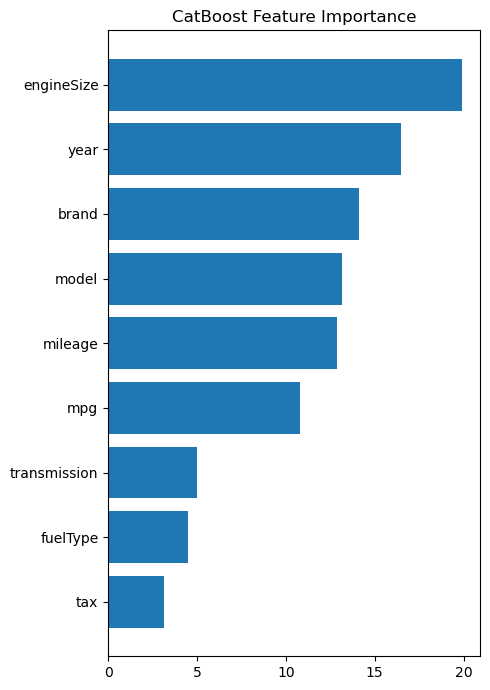

In [9]:
fig1 = optuna.visualization.plot_optimization_history(study)
fig1.show()
    
fig2 = optuna.visualization.plot_param_importances(study)
fig2.show()
    
# Plot feature importance from the final model
# Get feature importance values
feature_importance = final_model.get_feature_importance()

# Get sorted indices
sorted_idx = np.argsort(feature_importance)

# Plot
plt.figure(figsize=(5, 7))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])

# Use feature names if X is a DataFrame
feature_names = X.columns if hasattr(X, 'columns') else np.array(range(X.shape[1]))
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])

plt.title('CatBoost Feature Importance')
plt.tight_layout()
plt.show()

Check the [documentation](https://catboost.ai/en/docs/references/training-parameters/common) for hyperparameter tuning.

With proper hyperparameter tuning, CatBoost can achieve better performance than its default settings. However, even without tuning, CatBoost’s default configuration often outperforms the default settings of XGBoost and LightGBM, particularly on datasets with categorical features.

###  When to Use **CatBoost** Over **XGBoost**

- When your dataset is "categorical-heavy**
- **CatBoost** tends to perform well **out of the box** with minimal hyperparameter tuning, making it more user-friendly for quick experimentation or deployment  
- CatBoost’s **GPU implementation** is optimized for handling categorical data efficiently, and can **outperform XGBoost** on datasets dominated by categorical variables  
  > While both libraries support GPU acceleration, CatBoost's architecture is particularly well-suited for categorical-heavy tasks


##  Handling Imbalanced Classification: XGBoost vs. LightGBM vs. CatBoost

Imbalanced classification occurs when one class significantly outnumbers the other (e.g., fraud detection, disease diagnosis). Each boosting library offers tools to address this issue:


**XGBoost**:

- **Parameter**: `scale_pos_weight`
  - Formula:  
    $$
    \texttt{scale\_pos\_weight} = \frac{\text{Number of negative samples}}{\text{Number of positive samples}}
    $$
  - Increases the gradient of the positive class during training.
- **Additional Strategies**:
  - Use custom `eval_metric` (e.g., `"auc"`, `"aucpr"`, or `"logloss"`)
  - Apply early stopping on validation AUC



**LightGBM**:

- **Parameter**: `scale_pos_weight` (same as in XGBoost)
- **Alternative**: `is_unbalance = TRUE`
  - Automatically adjusts class weights based on distribution
- **Other Tips**:
  - Use `metric = "auc"` or `"binary_logloss"` for better guidance during training
  - Resampling techniques also compatible



**CatBoost**:

- **Parameter**: `class_weights`
  - Accepts a numeric vector (e.g., `class_weights = c(1, 5)` for [negative, positive])
  - Directly modifies the loss function to emphasize minority class
- **Advantages**:
  - More flexible than `scale_pos_weight`
  - Works well with default settings
- **Other Tips**:
  - Use `loss_function = "Logloss"` and `eval_metric = "AUC"` for binary classification



Below is the summary table:

| Library   | Imbalance Handling Parameter          | Default Support        | Recommended Metric         |
|-----------|----------------------------------------|-------------------------|-----------------------------|
| XGBoost   | `scale_pos_weight`                    | No                      | `auc`, `aucpr`              |
| LightGBM  | `scale_pos_weight`, `is_unbalance`    | Yes (with flag)         | `auc`, `binary_logloss`     |
| CatBoost  | `class_weights`                       | Yes                     | `Logloss`, `AUC`            |





##  Summary: XGBoost vs. LightGBM vs. CatBoost

Gradient boosting is a powerful ensemble technique, and XGBoost, LightGBM, and CatBoost are three of its most widely used implementations. Each has unique strengths and is well-suited to different use cases.

**XGBoost**: 

- **Strengths**: Robust, well-documented, strong performance on structured/tabular data  
- **Split Finding**: Level-wise tree growth  
- **Regularization**: Explicit L1 and L2 regularization  
- **Flexibility**: Highly customizable with many hyperparameters  
- **Best for**: General-purpose tabular data, especially when you have time to tune parameters

**LightGBM**: 

- **Strengths**: Fast training, low memory usage, excellent scalability  
- **Split Finding**: Leaf-wise tree growth with depth control  
- **Binning**: Uses histogram-based algorithm with `max_bin` to speed up training  
- **Best for**: Large-scale datasets, high-dimensional features, and when training speed matters

**CatBoost**:

- **Strengths**: Handles categorical features natively, works well with minimal tuning  
- **Boosting Innovation**: Uses *ordered boosting* to prevent prediction shift  
- **Categorical Encoding**: Uses target-based encoding internally  
- **Best for**: Datasets with many categorical variables or limited time for tuning



**Final Thoughts**

All three libraries are powerful and battle-tested. Here's a rough guideline:

- **Use XGBoost** if you want control, flexibility, and a well-documented standard
- **Use LightGBM** when training speed and large data scalability are your top priorities
- **Use CatBoost** when working with many categorical features or seeking strong baseline results with minimal tuning


## References

* [LightGBM Paper (Original NIPS 2017)](https://papers.nips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf)
* [LightGBM Official Website](https://lightgbm.readthedocs.io/)
* [CatBoost Paper (arXiv)](https://arxiv.org/abs/1810.11363)
* [CatBoost Official Website](https://catboost.ai/)
